# Average age at infection in the SIR model

Continuing our investigation of the Susceptible-Infected-Recovered model, we will add demographics and investigate the behavior of the model in and around the endemic equilibrium. 

$$
\dot{S} = -\frac{\beta*S*I}{N} + \mu N - \mu S \\
\\
\dot{I} = \frac{\beta*S*I}{N} - \gamma I - \mu I \\
\\
\dot{R} = \gamma I - \mu R
$$

Analysis of this system can be found in other sources (ref. Keeling/Rohani).  Setting the derivatives to zero and doing a bit of algebra gets you to the endemic equilbrium

$$
(S^*, \: I^*, \: R^*) = (\frac{1}{R_0}, \:\: \frac{\mu (R_0-1)}{\beta}, \: \: 1-\frac{1}{R_0} - \frac{\mu (R_0-1)}{\beta}) \\
\\
\text{where} \:\: R_0 = \frac{\beta}{\gamma + \mu}
$$

An individual susceptible's mean time to infection will then be the inverse of the total force of infection, $\beta I^*$.  
$$
\tau_{S \rightarrow I} = \frac{1}{\mu (R_0 -1)}
$$

The equation above is often also described as the average age at infection.  However, it is key to remember that the measured age at infection will be censored by non-disease deaths occurring at a rate $\mu$.  You can work through the impact of this, but in the simple case of constant mortality, it turns out to exactly balance out the $-1$ in the above equation, and so our *observed* average age at infection will be $\frac{1}{\mu R_0}$.  Since the hazard is constant at equilibrium, this implies an exponential distribution:

$$P(a | S->I) \sim \mu R_0 e^{-\mu R_0 a}$$

Alternatively, we can correct for the influence of mortality by observing the fraction of children who are susceptible at age A, which necessarily conditions on survival to age A.  This will look like the cumulative distribution of an exponential distributed according to the mean time to infection above:

$$P(R | a) \sim 1 - e^{(-a \mu (R_0-1))}$$

### Contruct the model

In this notebook, we will reproduce this dependence, and to do so, we will demonstrate how a LASER user can construct new model components on the fly for use with one of the packaged models. First, we note that the SIR model as built here does not actually output the needed information on the age at infection, only the dates of birth and death. The infection event happens in the `Transmission` step, so we will construct a new derived class (`TransmissionWithDOI`) to reproduce transmission behavior but also add and record a date of infection property for agents. Second, because this distribution is an equilibrium property of this system, we will build a model component to periodically import new infections, to ensure that infections don't burn out after the initial outbreak, and we are able to establish an endemic equilibrium (we could, instead, opt to initialize the model as near the endemic equilibrium as possible, but it is nicer to show that the model naturally goes there). Finally, we also need to model a large enough population to sustain the infection endemically (this population is known as the Critical Community Size and will be treated in notebook 7). The primary driver of the critical community size is actually not $R_0$ but the duration of infection, so setting the duration of infection to relatively long values ($\gamma = \frac {1} {60 \text {days}}$ 
) prevents us from needing huge agent populations. Finally, we construct a single-patch LASER model with five components: `VitalDynamics`, `Susceptibility`, `TransmissionWithDOI`, `Infection`, and `Importation`.

### Sanity check

The first test, as always, ensures that certain basic constraints are being obeyed by the model.

### Scientific test

The scientific test will sample a set of $(\mu, \gamma, R_0)$ tuples and confirm that both the age at infection and the fraction of susceptibles at a given age are well-described by exponential distributions and that the associated rate constant is as expected.   


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from laser.core.propertyset import PropertySet
from scipy.optimize import curve_fit
from scipy.stats import expon
from scipy.stats import kstest
from sklearn.metrics import mean_squared_error
from functools import partial

import laser.core.distributions as dists
from laser.core.demographics import AliasedDistribution
from laser.core.demographics import KaplanMeierEstimator
from laser.generic import SIR
from laser.generic import Model
from laser.generic.newutils import ValuesMap
from laser.core.utils import grid

print("done")
import laser.core
import laser.generic

print(f"{np.__version__=}")
print(f"{laser.core.__version__=}")
print(f"{laser.generic.__version__=}")


done
np.__version__='2.2.6'
laser.core.__version__='0.7.0'
laser.generic.__version__='0.0.0'


Here we build the modified Transmission class, to record date of infection.

In [2]:
import numba as nb
from laser.generic.shared import State

class TransmissionWithDOI(SIR.Transmission):
    def __init__(self, model, infdurdist, infdurmin: int =1):
        super().__init__(model, infdurdist, infdurmin)
        #After calling the superclass constructor, add an agent property "doi" to record date of infection
        self.model.people.add_scalar_property("doi", dtype=np.int32)  # Date of Infection
        self.model.people.doi[:] = -1
        
    #Next, define the Numba-accelerated transmission function - this looks like exactly like the one from the transmission class, 
    #but takes in the additional "doi" parameter and fills it with the current timestep upon infection
    @staticmethod
    @nb.njit(
        nogil=True,
        parallel=True,
    )
    def nb_transmission_doi(states, nodeids, ft, inf_by_node, itimers, infdurdist, infdurmin, tick, dois):
        for i in nb.prange(len(states)):
            if states[i] == State.SUSCEPTIBLE.value:
                # Check for infection
                draw = np.random.rand()
                nid = nodeids[i]
                if draw < ft[nid]:
                    states[i] = State.INFECTIOUS.value
                    dois[i] = tick  # Set date of infection
                    itimers[i] = np.maximum(np.round(infdurdist(tick, nid)), infdurmin)  # Set the infection timer
                    inf_by_node[nb.get_thread_id(), nid] += 1

        return

    #Finally, we define the step function, which again mirrors that of the Transmission class but calls the new nb_transmission_doi function and passes 
    #doi to it appropriately
    def step(self, tick: int) -> None:
        ft = self.model.nodes.forces[tick]

        N = self.model.nodes.S[tick] + (I := self.model.nodes.I[tick])  # noqa: E741
        # Shouldn't be any exposed (E), because this is an S->I model
        # Might have R.  
        if hasattr(self.model.nodes, "R"):
            N += self.model.nodes.R[tick]

        ft[:] = self.model.params.beta * I / N
        transfer = ft[:, None] * self.model.network
        ft += transfer.sum(axis=0)
        ft -= transfer.sum(axis=1)
        ft = -np.expm1(-ft)  # Convert to probability of infection

        inf_by_node = np.zeros((nb.get_num_threads(), self.model.nodes.count), dtype=np.uint32)
        self.nb_transmission_doi(
            self.model.people.state, self.model.people.nodeid, ft, inf_by_node, self.model.people.itimer, self.infdurdist, self.infdurmin,
            tick, self.model.people.doi # DOI specific parameters
        )
        inf_by_node = inf_by_node.sum(axis=0).astype(self.model.nodes.S.dtype)  # Sum over threads

        # state(t+1) = state(t) + ∆state(t)
        self.model.nodes.S[tick + 1] -= inf_by_node
        self.model.nodes.I[tick + 1] += inf_by_node
        # Record today's ∆
        self.model.nodes.newly_infected[tick] = inf_by_node

        return

Now we define the `Importation` class, which will periodically infect a few susceptibles to prevent die-out.

In [3]:
class Importation:
    def __init__(self, model, infdurdist, infdurmin: int =1, period: int = 180, count: int = 3):
        self.model = model
        self.infdurdist = infdurdist
        self.infdurmin = infdurmin
        self.period = period
        self.count = count

        self.model.nodes.add_vector_property("imports", model.params.nticks + 1, dtype=np.uint32, default=0)

        return
    
    def step(self, tick: int) -> None:
        if tick > 0 and tick % self.period == 0:
            i_susceptible = np.nonzero(self.model.people.state == SIR.State.SUSCEPTIBLE.value)[0]
            if len(i_susceptible) > 0:
                count = min(self.count, len(i_susceptible))
                i_infect = np.random.choice(i_susceptible, size=count, replace=False)
                self.model.people.state[i_infect] = SIR.State.INFECTIOUS.value
                samples = dists.sample_floats(self.infdurdist, np.zeros(count, np.float32))
                samples = np.round(samples)
                samples = np.maximum(samples, self.infdurmin).astype(self.model.people.itimer.dtype)
                self.model.people.itimer[i_infect] = samples
                inf_by_node = np.bincount(self.model.people.nodeid[i_infect], minlength=len(self.model.nodes)).astype(self.model.nodes.S.dtype)
                self.model.nodes.S[tick + 1] -= inf_by_node
                self.model.nodes.I[tick + 1] += inf_by_node
                self.model.nodes.imports[tick] = inf_by_node
            # else:
            #     print(f"No susceptibles to infect at tick {tick}")

        return


300,000 agents in 1 node(s): 100%|██████████| 10950/10950 [00:09<00:00, 1105.78it/s]


(array([9.612e+03, 7.494e+03, 5.988e+03, 4.738e+03, 3.589e+03, 2.782e+03,
        2.124e+03, 1.666e+03, 1.304e+03, 1.029e+03, 8.660e+02, 6.490e+02,
        5.080e+02, 4.200e+02, 2.880e+02, 2.250e+02, 1.910e+02, 1.240e+02,
        1.190e+02, 9.300e+01, 6.200e+01, 5.600e+01, 2.100e+01, 3.100e+01,
        2.300e+01, 2.300e+01, 2.000e+01, 1.400e+01, 7.000e+00, 4.000e+00,
        1.100e+01, 4.000e+00, 5.000e+00, 2.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00]),
 array([1.000000e+00, 9.032500e+01, 1.796500e+02, 2.689750e+02,
        3.583000e+02, 4.476250e+02, 5.369500e+02, 6.262750e+02,
        7.156000e+02, 8.049250e+02, 8.942500e+02, 9.835750e+02,
        1.072900e+03, 1.162225e+03, 1.251550e+03, 1.340875e+03,
        1.430200e+03, 1.519525e+03, 1.608850e+03, 1.698175e+03,
        1.787500e+03, 1.876825e+03, 1.966150e+03, 2.055475e+03,
        2.144800e+03, 2.234125e+03, 2.323450e+03, 2.412775e+03,
        2.502100e+03, 2.591425e+03, 2.680750e+03, 2.77

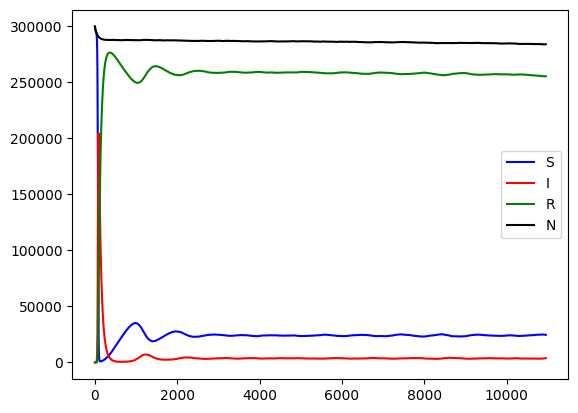

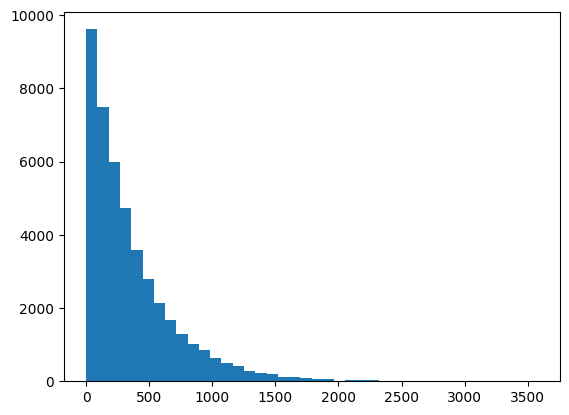

In [4]:
from laser.generic.vitaldynamics import BirthsByCBR, MortalityByEstimator

pop=3e5
scenario = grid(M=1, N=1, population_fn=lambda x,y: pop, origin_x=-(122+(19+(59/60))/60), origin_y=47+(36+(35/60))/60)
initial_infected = 1
scenario["S"] = scenario.population - initial_infected
scenario["I"] = initial_infected
scenario["R"] = 0
parameters = PropertySet(
    # {"seed": 4, "nticks": 18250, "verbose": True, "beta": 0.1, "inf_mean": 60, "cbr": 90, "importation_period": 180, "importation_count": 3}
    {"seed": 4, "nticks": 30*365, "verbose": True, "beta": 12/60, "inf_mean": 60, "cbr": 90, "importation_period": 180, "importation_count": 3}
)

birthrate_map = ValuesMap.from_scalar(parameters.cbr, nnodes=len(scenario), nsteps=parameters.nticks)
model = Model(scenario, parameters, birthrates=birthrate_map.values)
infdurdist = dists.exponential(scale=parameters.inf_mean)
rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) #to get stable population, small correction factor for the annual age-dist/KM estimators.
stable_age_dist = np.array(1000*np.exp(-rate_const*np.arange(89)))
pyramid = AliasedDistribution(stable_age_dist)
survival = KaplanMeierEstimator(stable_age_dist.cumsum())
model.components = [
    SIR.Susceptible(model),
    SIR.Recovered(model),
    SIR.Infectious(model, infdurdist),
    Importation(model, infdurdist),
    # SIR.Transmission(model, infdurdist),
    TransmissionWithDOI(model, infdurdist),
    BirthsByCBR(model, birthrate_map.values, pyramid=pyramid),
    MortalityByEstimator(model, estimator=survival),
]

model.run()
plt.plot(model.nodes.S, color="blue")
plt.plot(model.nodes.I, color="red")
plt.plot(model.nodes.R, color="green")
plt.plot(model.nodes.S+model.nodes.I+model.nodes.R, color="black")
plt.legend(["S", "I", "R", "N"])
plt.figure()
cut = (model.people.doi >= 365*28) 
plt.hist(model.people.doi[cut] - model.people.dob[cut], 40)

### Sanity checks
As always, check that we haven't broken anything - S+I+R = N at all times.

### First scientific test check
As usual, we will test this on a single simulation instance and demonstrate the analysis, before moving on to testing over a range of input values.  
Here, we are interested in equilibrium behavior, so I first place a cut to exclude all infections that occur before day 10000. We then plot the data, an exponential distribution with the expected value of $\frac{1}{R_0 \mu}$, a best-fit exponential distribution to the data, and perform a KS test. 

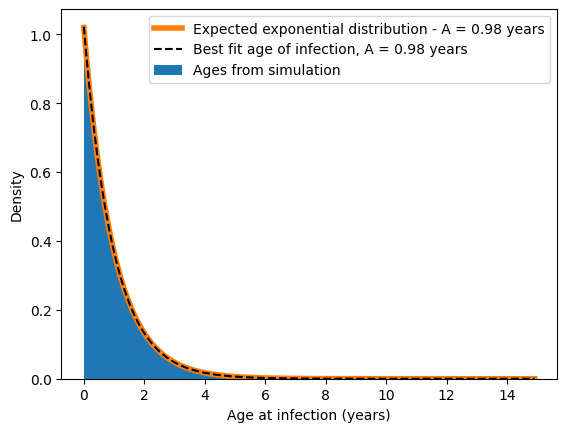

KstestResult(statistic=np.float64(0.0027030331151774445), pvalue=np.float64(0.009607305686942553), statistic_location=np.float64(0.09041095890410959), statistic_sign=np.int8(1))

In [5]:
mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
R0 = model.params.beta / (1 / model.params.inf_mean + mu)
A = 1 / (R0 * mu) / 365
a = np.arange(0, 15, 1/12)

def fit_age_at_infection(model, cutpos=5000):
    cut = model.people.doi > cutpos
    data = (model.people.doi[cut] - model.people.dob[cut]) / 365
    expfit = expon.fit(data)
    fitqual = kstest(data, expon.cdf, expfit)
    return data, expfit, fitqual

data, expfit, fitqual = fit_age_at_infection(model)

plt.hist(data, bins=a, density=True)
plt.plot(a, 1 / A * np.exp(-a / A), "-", lw=4)
plt.plot(a, expon.pdf(a, scale=expfit[1]), "k--")
plt.xlabel("Age at infection (years)")
plt.ylabel("Density")
plt.legend(
    [
        f"Expected exponential distribution - A = {A:.2f} years",
        f"Best fit age of infection, A = {expfit[1]:.2f} years",
        "Ages from simulation",
    ]
)
plt.show()
fitqual

### Second scientific test check
As noted above, because of the censoring that mortality induces, the distributions of age at infection vs. fraction susceptible at a given age will both follow exponential behavior but with a slight difference in the mean of the distribution - for the fraction susceptible, that value will be $\frac{1}{\mu (R_0-1)}$.  We develop this second test below. 

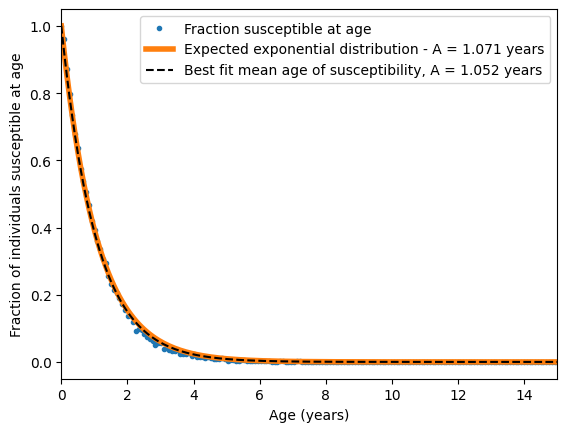

RMSE =  0.005588895978964833


In [6]:
A2 = 1 / ((R0 - 1) * mu) / 365


def Scurve(x, lam):
    return np.exp(-x / lam)


def fit_susceptibility_vs_age(model, cutpos=5000):
    cut = (model.people.state == State.SUSCEPTIBLE.value) & (model.people.dob > cutpos)
    bins = np.linspace(0, 15, 180)
    age_years = (np.max(model.people.dob) - model.people.dob) / 365
    n1 = np.histogram(age_years, bins=bins)[0]
    n2 = np.histogram(age_years[cut], bins=bins)[0]
    n1[n1 == 0] = 1
    y1 = n2 / n1
    popt, pcov = curve_fit(Scurve, bins[1:], y1, p0=2.5)
    mse = mean_squared_error(y1, Scurve(bins[1:], *popt))
    return y1, bins, popt, pcov, mse

data, bins, popt, pcov, mse = fit_susceptibility_vs_age(model)

# Plotting is a little more complicated here, want to plot at the bin centers and force y=1 at x=0
plt.plot([0, *bins[1:]], [1, *data], ".")
plt.plot([0, *bins[1:]], [1, *(Scurve(bins[1:], A2))], lw=4)
plt.plot([0, *bins[1:]], [1, *(Scurve(bins[1:], *popt))], "k--")
plt.legend(
    ["Fraction susceptible at age", f"Expected exponential distribution - A = {A2:.3f} years", f"Best fit mean age of susceptibility, A = {popt[0]:.3f} years"]
)
plt.xlabel("Age (years)")
plt.xlim(0, 15)
plt.ylabel("Fraction of individuals susceptible at age")
plt.show()
print("RMSE = ", np.sqrt(mse))


### Third scientific test
As long as we are here, let's test that the age distribution of the population is correct.  With constant birth rate, equal to death rate, the population should have exponentially distributed ages with parameter $\frac{1}{\mu}$

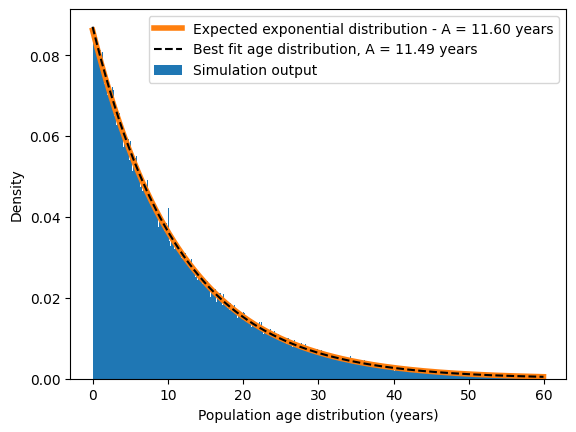

KstestResult(statistic=np.float64(0.003254250057994623), pvalue=np.float64(0.004868887343428581), statistic_location=np.float64(15.715068493150685), statistic_sign=np.int8(-1))

In [7]:
# Test that population age distribution is correct
def fit_population_age_distribution(model, max_age_years=100):
    tick = model.params.nticks
    cut = model.people.dod > tick
    age_years = (tick - model.people.dob[cut]) / 365
    expfit = expon.fit(age_years[age_years <= max_age_years])
    fitqual = kstest(age_years[age_years <= max_age_years], expon.cdf, expfit)
    return age_years, expfit, fitqual


age_years, expfit, fitqual = fit_population_age_distribution(model)
mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
A = 1 / mu / 365
a = np.arange(0, 60, 0.1)

plt.hist(age_years, bins=a, density=True)
plt.plot(a, 1 / A * np.exp(-a / A), "-", lw=4)
plt.plot(a, expon.pdf(a, scale=expfit[1]), "k--")
plt.xlabel("Population age distribution (years)")
plt.ylabel("Density")
plt.legend(
    [f"Expected exponential distribution - A = {A:.2f} years", f"Best fit age distribution, A = {expfit[1]:.2f} years", "Simulation output"]
)
plt.show()
fitqual



### Larger test suite
OK, so now we are going to replicate the above for many values of $R_0$ and cbr, as a scientific validity test.

We choose extremely high birth rates (7-10% per year) and $R_0$ (5-15), to give us systems that should equilibrate relatively quickly and prevent us from having to run for very long times.  

In [8]:
cbrs = 70 + 30 * np.random.rand(25)
R0s = 5 + 10 * np.random.rand(25)
pop = 1e5
initial_infected = 1
inf_mean = 90
output = pd.DataFrame(data={"cbr": cbrs, "R0": R0s})
output["Average_Iage_observed"] = np.nan
output["Average_Iage_expected"] = np.nan
output["Average_Sage_observed"] = np.nan
output["Average_Sage_expected"] = np.nan
output["Average_age_expected"] = np.nan
output["Average_age_expected"] = np.nan

for index, row in output.iterrows():
    parameters = PropertySet(
        {
            "seed": 2,
            "nticks": 365*50,
            "verbose": True,
            "beta": row["R0"] * (mu + 1 / inf_mean),
            "inf_mean": inf_mean,
            "cbr": row["cbr"],
            "importation_period": 180,
            "importation_count": 3,
        }
    )
    scenario = grid(M=1, N=1, population_fn=lambda x,y: pop, origin_x=0, origin_y=0)
    scenario["I"] = initial_infected
    scenario["R"] = np.round(pop * (1 / row["R0"] - 0.05)).astype(np.int32)
    scenario["S"] = scenario.population - scenario["I"] - scenario["R"]

    parameters = PropertySet(
        {"seed": index, "nticks": 365*50, "verbose": True, "beta": parameters.beta, "inf_mean": parameters.inf_mean, "cbr": parameters.cbr, "importation_period": 180, "importation_count": 3}
    )
    birthrate_map = ValuesMap.from_scalar(parameters.cbr, nnodes=len(scenario), nsteps=parameters.nticks)
    model = Model(scenario, parameters, birthrates=birthrate_map.values)

    infdurdist = dists.exponential(scale=parameters.inf_mean)
    rate_const = 365 * ((1 + parameters.cbr / 1000) ** (1/365) - 1) #to get stable population, small correction factor for the annual age-dist/KM estimators.
    pyramid = AliasedDistribution(stable_age_dist:=np.array(1000*np.exp(-rate_const*np.arange(89))))
    survival = KaplanMeierEstimator(stable_age_dist.cumsum())

    model.components = [
        SIR.Susceptible(model),
        SIR.Recovered(model),
        SIR.Infectious(model, infdurdist),
        Importation(model, infdurdist),
        TransmissionWithDOI(model, infdurdist),
        BirthsByCBR(model, birthrate_map.values, pyramid=pyramid),
        MortalityByEstimator(model, estimator=survival),
    ]

    model.run(f"Running model {index+1} of {len(output)} with R0={row['R0']:.2f}, cbr={row['cbr']:.2f}")
    mu = (1 + model.params.cbr / 1000) ** (1 / 365) - 1
    _, expfit, _ = fit_age_at_infection(model, 365*40)

    output.loc[index, "Average_Iage_expected"] = 1 / (row["R0"] * mu) / 365
    output.loc[index, "Average_Iage_observed"] = expfit[1]

    # _, _, popt, _, _ = fit_susceptibility_vs_age(model, 365*20)
    # output.loc[index, "Average_Sage_expected"] = 1 / ((row["R0"] - 1) * mu) / 365
    # output.loc[index, "Average_Sage_observed"] = popt[0]

    # _, expfit, _ = fit_population_age_distribution(model)
    # output.loc[index, "Average_age_expected"] = 1 / mu / 365
    # output.loc[index, "Average_age_observed"] = expfit[1]


Running model 25 of 25 with R0=7.99, cbr=87.18: 100%|██████████| 18250/18250 [00:13<00:00, 1334.74it/s]


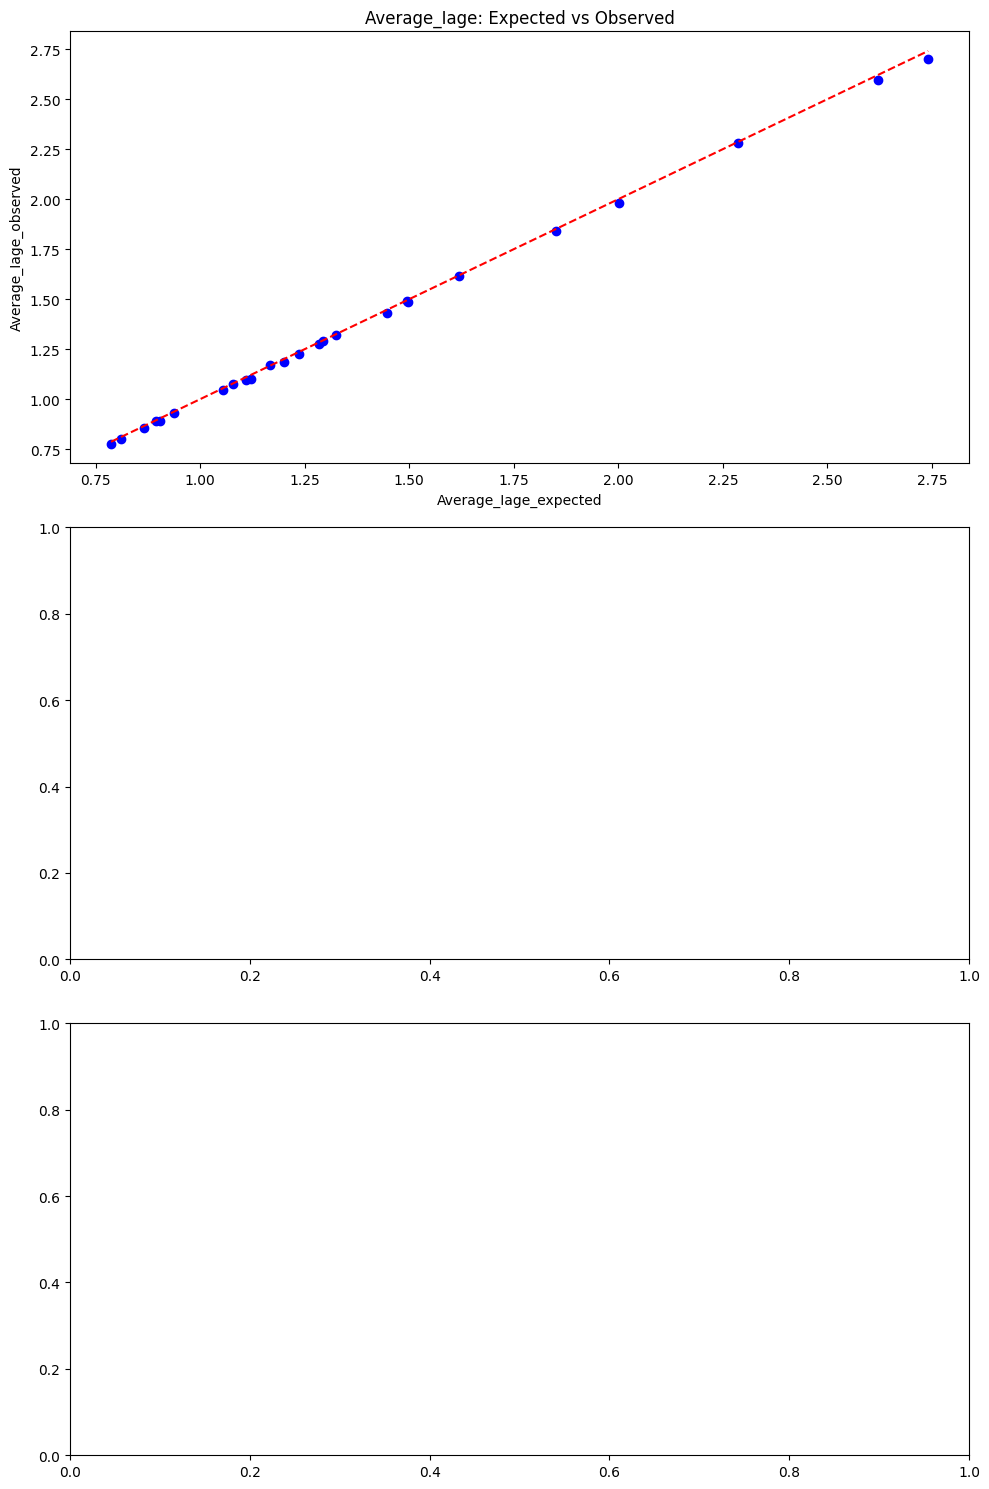

Average fractional deviation for Iage: 0.008248949240299475
Max deviation for Iage: 0.018309488463210857
Number of sims >5% away for Iage: 0
Number of sims >10% away for Iage: 0


In [9]:
# Plotting the expected and observed values
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# Plot for Average_Iage
axes[0].scatter(output["Average_Iage_expected"], output["Average_Iage_observed"], c="blue")
axes[0].plot(
    [output["Average_Iage_expected"].min(), output["Average_Iage_expected"].max()],
    [output["Average_Iage_expected"].min(), output["Average_Iage_expected"].max()],
    "r--",
)
axes[0].set_xlabel("Average_Iage_expected")
axes[0].set_ylabel("Average_Iage_observed")
axes[0].set_title("Average_Iage: Expected vs Observed")

# # Plot for Average_Sage
# axes[1].scatter(output["Average_Sage_expected"], output["Average_Sage_observed"], c="green")
# axes[1].plot(
#     [output["Average_Sage_expected"].min(), output["Average_Sage_expected"].max()],
#     [output["Average_Sage_expected"].min(), output["Average_Sage_expected"].max()],
#     "r--",
# )
# axes[1].set_xlabel("Average_Sage_expected")
# axes[1].set_ylabel("Average_Sage_observed")
# axes[1].set_title("Average_Sage: Expected vs Observed")

# # Plot for Average_age
# axes[2].scatter(output["Average_age_expected"], output["Average_age_observed"], c="purple")
# axes[2].plot(
#     [output["Average_age_expected"].min(), output["Average_age_expected"].max()],
#     [output["Average_age_expected"].min(), output["Average_age_expected"].max()],
#     "r--",
# )
# axes[2].set_xlabel("Average_age_expected")
# axes[2].set_ylabel("Average_age_observed")
# axes[2].set_title("Average_age: Expected vs Observed")

plt.tight_layout()
plt.show()

# Testing whether the expected and observed values are within 10% of each other
within_10_percent_Iage = np.abs(output["Average_Iage_expected"] - output["Average_Iage_observed"]) / output["Average_Iage_expected"] <= 0.1
#within_10_percent_Sage = np.abs(output["Average_Sage_expected"] - output["Average_Sage_observed"]) / output["Average_Sage_expected"] <= 0.1
#within_10_percent_age = np.abs(output["Average_age_expected"] - output["Average_age_observed"]) / output["Average_age_expected"] <= 0.1
# Calculate deviations
deviation_Iage = np.abs(output["Average_Iage_expected"] - output["Average_Iage_observed"]) / output["Average_Iage_expected"]
#deviation_Sage = np.abs(output["Average_Sage_expected"] - output["Average_Sage_observed"]) / output["Average_Sage_expected"]
#deviation_age = np.abs(output["Average_age_expected"] - output["Average_age_observed"]) / output["Average_age_expected"]

# Print average fractional deviation
print(f"Average fractional deviation for Iage: {deviation_Iage.mean()}")
#print(f"Average fractional deviation for Sage: {deviation_Sage.mean()}")
#print(f"Average fractional deviation for age: {deviation_age.mean()}")

# Print max deviation
print(f"Max deviation for Iage: {deviation_Iage.max()}")
#print(f"Max deviation for Sage: {deviation_Sage.max()}")
#print(f"Max deviation for age: {deviation_age.max()}")

# Print number of sims >5% and 10% away from expectation
print(f"Number of sims >5% away for Iage: {(deviation_Iage > 0.05).sum()}")
print(f"Number of sims >10% away for Iage: {(deviation_Iage > 0.1).sum()}")
#print(f"Number of sims >5% away for Sage: {(deviation_Sage > 0.05).sum()}")
#print(f"Number of sims >10% away for Sage: {(deviation_Sage > 0.1).sum()}")
#print(f"Number of sims >5% away for age: {(deviation_age > 0.05).sum()}")
#print(f"Number of sims >10% away for age: {(deviation_age > 0.1).sum()}")

In [10]:
model.params.beta*90

np.float64(8.159190366780813)

In [11]:
output

,cbr,R0,Average_Iage_observed,Average_Iage_expected,Average_Sage_observed,Average_Sage_expected,Average_age_expected
0,71.803858,5.500771,2.594678,2.621393,NaN,NaN,NaN
1,73.246152,10.675694,1.320684,1.325004,NaN,NaN,NaN
2,92.290468,10.750238,1.045897,1.053617,NaN,NaN,NaN
3,86.903605,9.988245,1.188137,1.201281,NaN,NaN,NaN
4,77.648982,6.682437,1.983191,2.000897,NaN,NaN,NaN
5,89.135209,10.030114,1.170924,1.167527,NaN,NaN,NaN
6,80.964562,7.932479,1.615304,1.619068,NaN,NaN,NaN
7,99.519864,8.144928,1.288870,1.293930,NaN,NaN,NaN
8,87.033417,14.797854,0.799288,0.809679,NaN,NaN,NaN
9,86.381218,13.507796,0.890390,0.893433,NaN,NaN,NaN
